In [37]:
# 1. Import libraries
import pandas as pd

# 2. Load the dataset (student-mat.csv)
df = pd.read_csv("data/student-mat.csv", sep=';')  # Use sep=';' as it's not comma-separated
print("✅ Dataset loaded successfully with shape:", df.shape)

# 3. Preview the dataset
df.head()


✅ Dataset loaded successfully with shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [38]:
# 1. Column data types and null checks
df.info()

# 2. Summary stats for numeric columns
df.describe()

# 3. Count unique values in categorical columns
df.select_dtypes(include='object').nunique()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

In [39]:
def classify_mental_health_risk(row):
    risk_score = 0

    if row['G3'] < 10:
        risk_score += 1
    if row['failures'] >= 1:
        risk_score += 1
    if (row['Walc'] + row['Dalc']) >= 6:
        risk_score += 1
    if row['health'] <= 2:
        risk_score += 1
    if row['studytime'] < 2 and row['absences'] > 10:
        risk_score += 1

    # Classify risk level
    if risk_score >= 3:
        return 'High'
    elif risk_score == 2:
        return 'Medium'
    else:
        return 'Low'

# Apply to dataset
df['mental_health_risk'] = df.apply(classify_mental_health_risk, axis=1)

# Preview distribution
df['mental_health_risk'].value_counts()


Low       291
Medium     73
High       31
Name: mental_health_risk, dtype: int64

In [40]:
# Copy original to preserve raw version
df_model = df.copy()

# Drop these to avoid leakage
df_model = df_model.drop(columns=['G1', 'G2', 'G3'])



In [41]:
df_model['risk_label'] = df_model['mental_health_risk'].map({'Low': 0, 'Medium': 1, 'High': 2})
df_model = df_model.drop(columns=['mental_health_risk'])


In [42]:
df_model = pd.get_dummies(df_model, drop_first=True)


In [43]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_model.drop('risk_label', axis=1)
y = df_model['risk_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))



Logistic Regression Accuracy: 0.7974683544303798

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90        58
           1       0.50      0.33      0.40        15
           2       1.00      0.17      0.29         6

    accuracy                           0.80        79
   macro avg       0.78      0.49      0.53        79
weighted avg       0.79      0.80      0.76        79


Confusion Matrix:
 [[57  1  0]
 [10  5  0]
 [ 1  4  1]]


/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.7468354430379747

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        58
           1       0.33      0.27      0.30        15
           2       0.00      0.00      0.00         6

    accuracy                           0.75        79
   macro avg       0.38      0.40      0.39        79
weighted avg       0.67      0.75      0.70        79


Confusion Matrix:
 [[55  3  0]
 [11  4  0]
 [ 1  5  0]]


/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [46]:
y_train.value_counts()


0    233
1     58
2     25
Name: risk_label, dtype: int64

In [47]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [48]:
!pip install imbalanced-learn



In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Random Forest with class_weight='balanced'
rf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_bal.fit(X_train, y_train)
y_pred_bal = rf_bal.predict(X_test)

print("Random Forest (class_weight='balanced') Accuracy:", accuracy_score(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))


# Random Forest after SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = rf_smote.predict(X_test)

print("\n\nRandom Forest (SMOTE) Accuracy:", accuracy_score(y_test, y_pred_sm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_sm))


Random Forest (class_weight='balanced') Accuracy: 0.7468354430379747

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88        58
           1       0.29      0.13      0.18        15
           2       0.00      0.00      0.00         6

    accuracy                           0.75        79
   macro avg       0.36      0.37      0.35        79
weighted avg       0.64      0.75      0.68        79


Confusion Matrix:
 [[57  1  0]
 [13  2  0]
 [ 2  4  0]]


Random Forest (SMOTE) Accuracy: 0.7848101265822784

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90        58
           1       0.40      0.27      0.32        15
           2       1.00      0.33      0.50         6

    accuracy                           0.78        79
   macro avg       0.75      0.52      0.57        79
weighted avg       0.77      0.78      0.76        79


Confusio

/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/asmitadeshpande/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

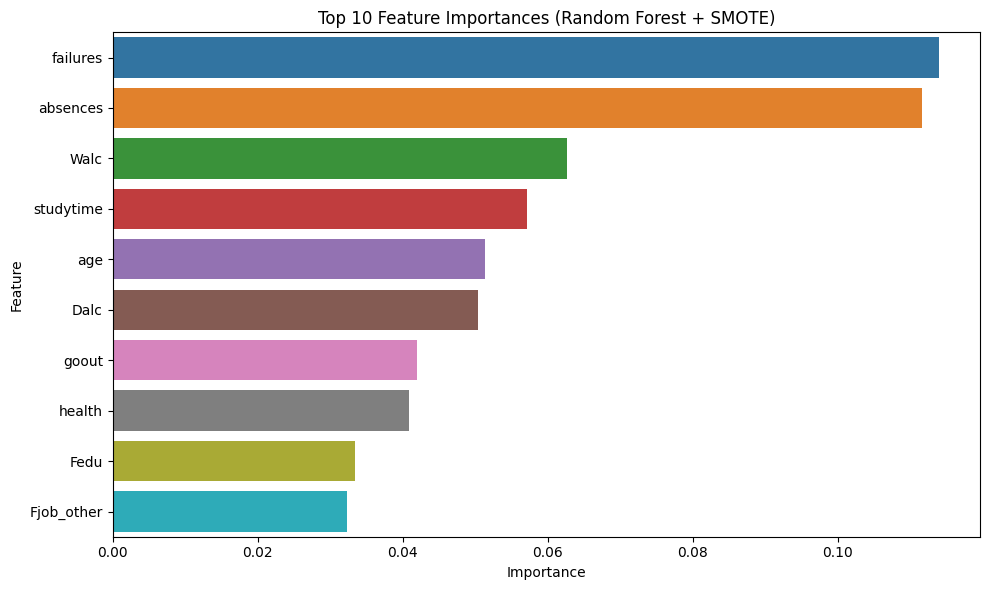

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from final SMOTE model
importances = rf_smote.feature_importances_
features = X_train.columns

# Plot top 10
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Feature Importances (Random Forest + SMOTE)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [51]:
import shap

# Sample 100 rows for SHAP (avoid long compute)
explainer = shap.TreeExplainer(rf_smote)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values[1], X_test, plot_type="bar")



AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install shap



In [ ]:
import shap

explainer = shap.TreeExplainer(rf_smote)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")


In [ ]:
import shap

# Create explainer and SHAP values
explainer = shap.TreeExplainer(rf_smote)
shap_values = explainer.shap_values(X_test)

# Plot summary for all classes (bar = global importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
df_export = df.copy()
df_export.to_csv("student_mental_health_final.csv", index=False)


In [ ]:
df['mental_health_risk'] = risk_level_predictions  # where risk_level_predictions contains "Low", "Medium", "High"
df.to_csv("student_mental_health_final.csv", index=False)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# After training
y_pred = rf_smote.predict(X_test)


In [ ]:
risk_map = {0: "Low", 1: "Medium", 2: "High"}
risk_level_predictions = [risk_map[i] for i in y_pred]


In [ ]:
df_test_copy = X_test.copy()  # or merge with original df if needed
df_test_copy['mental_health_risk'] = risk_level_predictions


In [ ]:
df_test_copy.to_csv("student_mental_health_final.csv", index=False)


In [53]:
# 1. Predict risk level for the ENTIRE dataset
y_full_pred = rf_smote.predict(X)

# 2. Convert numeric predictions to labels
risk_map = {0: "Low", 1: "Medium", 2: "High"}
df['mental_health_risk'] = [risk_map[i] for i in y_full_pred]

# 3. Save the full DataFrame with risk levels to CSV
df.to_csv("student_mental_health_final.csv", index=False)
